# (1) 데이터 준비와 확인

In [2]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# (2) 데이터로더 구성

- 데이터의 중복 제거

- NaN 결측치 제거

- 한국어 토크나이저로 토큰화

- 불용어(Stopwords) 제거

- 사전word_to_index 구성

- 텍스트 스트링을 사전 인덱스 스트링으로 변환

- X_train, y_train, X_test, y_test, word_to_index 리턴


knolpy를 사용할건데 미리 불용어를 정의합니다.

In [ ]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

중복되는 데이터나 결측치를 제거해주는 함수를 생성하는데 mecab을 이용하여 한국어 토큰화 작업을 진행합니다. word_to_index를 만들 때에는 미리 정의한 pad, bos, unk, unused를 제외하고 빈도 수가 높은 단어 10,000개의 단어를 가져오는 딕셔너리를 생성합니다.

In [3]:
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [16]:
print("훈련 샘플 개수: {}, 테스트 개수: {}". format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# (3) 모델구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포

- 적절한 최대 문장 길이 지정

- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가


In [10]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969355837799927
문장길이 최대 :  116
문장길이 표준편차 :  12.843536204665021
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [17]:
#패딩 추가

X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


# (4) validation set 구성

validation set을 먼저 구성하겠습니다.

In [25]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


# (5) 모델 구성 및 훈련 개시

## 1. LSTM

LSTM state 벡터의 차원수는 8에서 128로 조정

In [35]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model.summary()


model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 2,169,489
Trainable params: 2,169,489
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 200)         2000000   
______________________

## 모델 훈련

In [36]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Train on 136182 samples, validate on 10000 samples
Epoch 1/20
136182/136182 [==============================] - 9s 63us/sample - loss: 0.4576 - accuracy: 0.7596 - val_loss: 0.3463 - val_accuracy: 0.8499
Epoch 2/20
136182/136182 [==============================] - 7s 54us/sample - loss: 0.3257 - accuracy: 0.8605 - val_loss: 0.3263 - val_accuracy: 0.8557
Epoch 3/20
136182/136182 [==============================] - 7s 55us/sample - loss: 0.2877 - accuracy: 0.8767 - val_loss: 0.3201 - val_accuracy: 0.8579
Epoch 4/20
136182/136182 [==============================] - 7s 54us/sample - loss: 0.2593 - accuracy: 0.8915 - val_loss: 0.3306 - val_accuracy: 0.8573
Epoch 5/20
136182/136182 [==============================] - 8s 56us/sample - loss: 0.2339 - accuracy: 0.9027 - val_loss: 0.3518 - val_accuracy: 0.8566
Epoch 6/20
136182/136182 [==============================] - 7s 54us/sample - loss: 0.2117 - accuracy: 0.9136 - val_loss: 0.3598 - val_accuracy: 0.8580
Epoch 7/20
136182/136182 [=================

## (2)maxpooling

In [31]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.GlobalMaxPooling1D())
model3.add(keras.layers.Dense(8, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 2,322,417
Trainable params: 2,322,417
Non-trainable params: 0
_________________________________________________________________


## 모델 훈련

In [32]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Train on 136182 samples, validate on 10000 samples
Epoch 1/20
136182/136182 [==============================] - 10s 74us/sample - loss: 0.0625 - accuracy: 0.9759 - val_loss: 0.7916 - val_accuracy: 0.8428
Epoch 2/20
136182/136182 [==============================] - 9s 64us/sample - loss: 0.0542 - accuracy: 0.9793 - val_loss: 0.7945 - val_accuracy: 0.8401
Epoch 3/20
136182/136182 [==============================] - 9s 65us/sample - loss: 0.0514 - accuracy: 0.9808 - val_loss: 0.8135 - val_accuracy: 0.8402
Epoch 4/20
136182/136182 [==============================] - 9s 65us/sample - loss: 0.0481 - accuracy: 0.9817 - val_loss: 0.9101 - val_accuracy: 0.8420
Epoch 5/20
136182/136182 [==============================] - 9s 65us/sample - loss: 0.0445 - accuracy: 0.9828 - val_loss: 0.8818 - val_accuracy: 0.8438
Epoch 6/20
136182/136182 [==============================] - 9s 65us/sample - loss: 0.0436 - accuracy: 0.9832 - val_loss: 0.8094 - val_accuracy: 0.8385
Epoch 7/20
136182/136182 [================

## (3) conv

In [33]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.MaxPooling1D(5))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

## 모델 훈련

In [34]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Train on 136182 samples, validate on 10000 samples
Epoch 1/20
136182/136182 [==============================] - 10s 74us/sample - loss: 0.0230 - accuracy: 0.9910 - val_loss: 1.1214 - val_accuracy: 0.8368
Epoch 2/20
136182/136182 [==============================] - 9s 65us/sample - loss: 0.0194 - accuracy: 0.9923 - val_loss: 1.1204 - val_accuracy: 0.8364
Epoch 3/20
136182/136182 [==============================] - 9s 65us/sample - loss: 0.0201 - accuracy: 0.9921 - val_loss: 1.0352 - val_accuracy: 0.8398
Epoch 4/20
136182/136182 [==============================] - 9s 65us/sample - loss: 0.0201 - accuracy: 0.9921 - val_loss: 1.0279 - val_accuracy: 0.8362
Epoch 5/20
136182/136182 [==============================] - 9s 65us/sample - loss: 0.0204 - accuracy: 0.9921 - val_loss: 1.0825 - val_accuracy: 0.8430
Epoch 6/20
136182/136182 [==============================] - 9s 65us/sample - loss: 0.0183 - accuracy: 0.9929 - val_loss: 1.0168 - val_accuracy: 0.8386
Epoch 7/20
136182/136182 [================

# (6) Loss, Accuracy 그래프 시각화

학습이 끝난 모델을 테스트 셋으로 평가

In [38]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

49157/49157 - 3s - loss: 0.7597 - accuracy: 0.8395
[0.7596737972666459, 0.8394939]


In [39]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


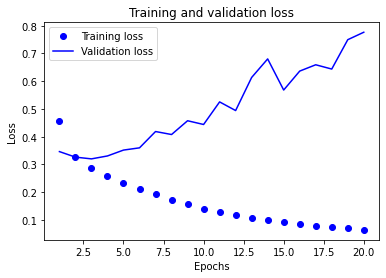

In [40]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

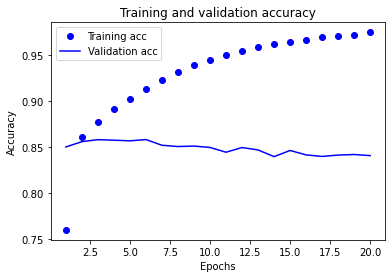

In [41]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# (7) 학습된 Embedding 레이어 분석

In [42]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


In [43]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [49]:

from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

array([ 1.21005163e-01,  4.05087732e-02,  9.40833390e-02,  9.67747569e-02,
       -3.68815362e-02,  4.82934667e-03, -1.39623687e-01,  5.25927022e-02,
       -1.02086037e-01,  8.83680582e-02, -1.21253900e-01,  1.54756717e-02,
       -2.42201254e-01,  1.01795286e-01, -3.17689329e-02,  7.13486224e-02,
        3.62348743e-02, -1.28145263e-01,  3.36258523e-02, -1.67794704e-01,
        3.83729972e-02,  4.26819623e-02, -1.00424364e-01, -6.55174106e-02,
        8.88161436e-02,  1.29682034e-01, -1.24914488e-02,  4.96732742e-02,
       -2.14933418e-02, -1.79431736e-01,  7.78247714e-02, -1.05941564e-01,
        4.32067811e-02, -1.41335145e-01, -1.33700613e-02,  6.26623258e-02,
       -7.75781497e-02,  5.08713238e-02,  3.60164717e-02, -1.08280420e-01,
        1.94126461e-02, -1.28092319e-01,  9.98223200e-02,  3.72096077e-02,
       -8.77892151e-02, -7.60105103e-02,  6.50536418e-02,  5.24653979e-02,
        1.21241763e-01,  1.33398041e-01,  1.21877909e-01,  2.00521965e-02,
        1.07108690e-01,  

In [50]:
word_vectors.similar_by_word("사랑")

[('명작', 0.8614985346794128),
 ('대조', 0.8524621725082397),
 ('담아낸', 0.8462417125701904),
 ('직설', 0.8422785997390747),
 ('최고', 0.8247392177581787),
 ('여운', 0.8194774985313416),
 ('나와도', 0.8176375031471252),
 ('비포', 0.8173232078552246),
 ('깊', 0.815139889717102),
 ('재밌', 0.8124272227287292)]

# (8) 한국어 Word2Vec 임베딩 활용하여 성능개선

In [54]:
from gensim.models import Word2Vec
word2vec_path = '/home/aiffel-dj31/aiffel/sentiment_classification/ko.bin'
word2vec = Word2Vec.load(word2vec_path)
vector = word2vec['사랑']
vector

/home/aiffel-dj31/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


array([-1.3740246 , -1.7353463 ,  3.3915305 , -2.569253  , -1.4016607 ,
        1.4556127 ,  0.9414557 ,  1.9207907 ,  0.16471806,  0.4838317 ,
       -0.8547181 ,  2.0879807 ,  0.86741775,  0.87539405, -0.09962013,
        0.22928311, -1.1858722 ,  0.00858838,  1.4999928 , -0.16196461,
       -0.35184434, -0.92390764,  1.0849575 ,  0.3025011 ,  2.7021565 ,
       -1.0263684 ,  0.32864776, -0.76589465, -2.510981  , -0.66225356,
        2.8434615 ,  0.50130975, -1.021874  , -1.4366034 ,  1.1110784 ,
        0.5812605 , -0.5830406 , -0.5785423 ,  1.3634988 ,  2.3074338 ,
       -1.4314893 ,  0.45745876,  1.1073523 , -3.2135262 , -0.2898375 ,
       -1.1622221 ,  1.2369208 , -0.7622987 , -0.37757635,  1.1376442 ,
        0.01065568, -0.69105595,  1.5159112 ,  1.1534518 , -1.0119992 ,
       -0.5757404 ,  1.1349088 , -1.1289831 ,  0.13004152,  2.0451715 ,
       -0.23940353,  1.3604902 ,  0.72700524,  0.32545742,  1.0612459 ,
        0.42252553,  1.1442151 ,  2.8774905 ,  2.4377263 , -1.34

In [56]:
word2vec.similar_by_word("사랑")

/home/aiffel-dj31/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('슬픔', 0.7216663360595703),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985676765442),
 ('기쁨', 0.6458414793014526),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937871932983),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206068992614746),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [57]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/aiffel-dj31/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel-dj31/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [58]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [60]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Train on 136182 samples, validate on 10000 samples
Epoch 1/20
136182/136182 [==============================] - 8s 57us/sample - loss: 0.5322 - accuracy: 0.7259 - val_loss: 0.4221 - val_accuracy: 0.8090
Epoch 2/20
136182/136182 [==============================] - 7s 48us/sample - loss: 0.3792 - accuracy: 0.8322 - val_loss: 0.3648 - val_accuracy: 0.8401
Epoch 3/20
136182/136182 [==============================] - 7s 48us/sample - loss: 0.3261 - accuracy: 0.8600 - val_loss: 0.3556 - val_accuracy: 0.8427
Epoch 4/20
136182/136182 [==============================] - 6s 47us/sample - loss: 0.2935 - accuracy: 0.8771 - val_loss: 0.3421 - val_accuracy: 0.8525
Epoch 5/20
136182/136182 [==============================] - 6s 47us/sample - loss: 0.2679 - accuracy: 0.8901 - val_loss: 0.3447 - val_accuracy: 0.8529
Epoch 6/20
136182/136182 [==============================] - 6s 47us/sample - loss: 0.2458 - accuracy: 0.9009 - val_loss: 0.3622 - val_accuracy: 0.8504
Epoch 7/20
136182/136182 [=================

In [62]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

49157/49157 - 2s - loss: 0.8013 - accuracy: 0.8271
[0.8013117826645545, 0.82708466]


정확도 0.8271

# 루브릭 평가
1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.

lstm, conv, maxpooling 모델

2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.

gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함

3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.

정확도 82.7%

# 총평고

여태 노드 중 가장 어려웠던 노드였다. 자연어 처리의 개념이 아직도 잡히지 않은 상태인데 너무 세세한 것에 집중하느라 큰 틀을 보지 못했다. 하이퍼파라미터가 완벽히 어떤 영향을 끼치는지 깨닫지는 못했지만 느낌을 점점 잡아가고 있는 중이다. 이번에도 파이썬 코드를 보다 흡수하지 못한것이 아쉬웠고 노드 전에 문법부터 확실히 잡아두어야겠다는 생각이 들었다. 노드가 워낙 설명이 잘 되어 있지 않아 필요 개념을 일일이 찾아보면서 진행했는데 아직도 불분명한 것이 많아 자연어는 처음부터 다시 공부해야겠다.